In [4]:
import torch
import matplotlib.pyplot as plt

In [9]:
def bbox_to_rect(bbox, color):
  # 将边界框(左上x，左上y，右下x, 右下y)格式转换成matplotlib格式
  # ((左上x,左上y)，宽，高)
  return plt.Rectangle(
    xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
    fill=False, edgecolor=color, linewidth=2
  )

目标检测会在图像上采样大量区域，判断是否包含感兴趣的目标

In [5]:
# 精简输出精度
torch.set_printoptions(2)

In [6]:
def multibox_prior(data, sizes, ratios):
  """生成以每个像素为中心具有不同形状的锚框"""
  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)
  
  # 为了将锚点移动到像素中心，需要设置偏移量
  # 因为一个像素的高为1且宽为1， 偏移中心0.5
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # 在y轴上缩放步长
  steps_w = 1.0 / in_width  # 在x轴上缩放步长
  
  # 生成锚框的所有中心点
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
  shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
  
  # 生成“boxes_per_pixel”个高和宽,
  # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
  sizes[0] * torch.sqrt(ratio_tensor[1:])))\
  * in_height / in_width # 处理矩形输入
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
  sizes[0] / torch.sqrt(ratio_tensor[1:])))
  # 除以2来获得半高和半宽
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
  in_height * in_width, 1) / 2
  # 每个中心点都将有“boxes_per_pixel”个锚框,
  # 所以生成含所有锚框中心的网格,重复了“boxes_per_pixel”次
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
    dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0)

In [11]:
img = plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
print(h,w)
X = torch.rand(size=(1,3,h,w))
Y = multibox_prior(X,sizes=[0.75, 0.5, 0.25], ratios=[1,2,0.5])
Y.shape
boxes = Y.reshape(h,w,5,4)

561 728


In [10]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
  """显示所有边界框"""
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list,tuple)):
      obj = [obj]
    return obj
  
  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i,bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = bbox_to_rect(bbox.detach().numpy(), color)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i],
                va="center", ha="center", fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

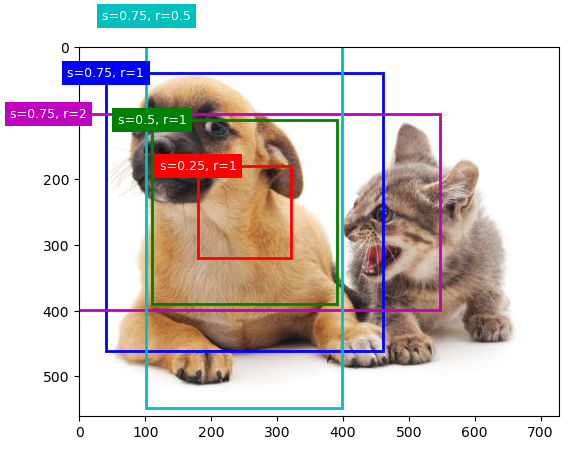

In [12]:
bbox_scale = torch.tensor((w,h,w,h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250,250,:,:] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
's=0.75, r=0.5'])